# Examples for EPTools
@copyright by Runduo Liang (Aujust)

## Crossmatch

In [3]:
import sys
sys.path.append('$HEADAS/lib/python')
import EPTools
from astropy.coordinates import SkyCoord
from EPTools.utils import *
import numpy as np
from astropy.cosmology import Planck18
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier, VizierClass
from ligo.skymap.postprocess import crossmatch
from astropy.table import Table
from ligo.skymap.io.fits import read_sky_map

#!source ~/.bashrc heasoft
#from xspec import *
#from astropy.config import create_config_file
#from astropy.config import get_config_dir
#create_config_file('astropy')
#get_config_dir()

### Get archival lc

In [4]:
cross = EPTools.Crossmatch()
pos = '24.505 -1.171'
lc = cross.ztf_lc(pos,band='g',match_rad=50)
print(np.unique(lc['oid']))

      oid       
----------------
 399110100006102
 399110100006142
 399110100006154
 399110100006189
 399110100010684
 399110100010729
1444103200000461
1444103200023566
1444103200024614


[671.85294449]
[11.18438943]


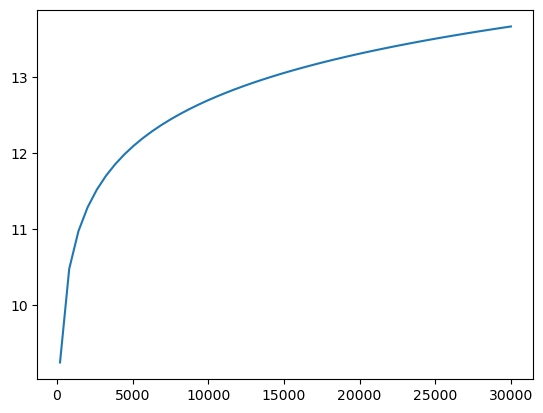

In [13]:
model = sncosmo.Model(source='hsiao')
model.set(z=0.05, t0=0., amplitude=1.e-3)
print(model.bandflux('sdssi',time=[100],zp=20,zpsys='ab')/5)
print(model.bandmag('sdssi','ab',time=[100]))

expos = np.linspace(200,30000,50)
plt.plot(expos,EPexpo2mAB(expos,instrument='FXT'))

### Fit WXT & FXT sensitivity vs. expo time

[5.49101782e-11 8.12917739e-01]


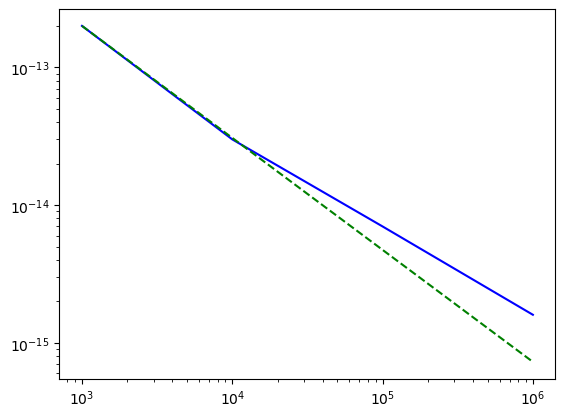

In [7]:
from scipy.optimize import curve_fit
#WXT
#xdata = np.array([10,100,1000])
#ydata = np.array([9e-10,1.3e-10,2.6e-11])

#FXT
xdata = np.array([1e3,1e4,1e5,1e6])
ydata = np.array([2e-13,3e-14,7e-15,1.6e-15])


def pw(x, norm,p):
    return norm * x**-p

popt, pcov = curve_fit(pw, xdata, ydata)
print(popt)
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, pw(xdata, *popt), 'g--')
plt.xscale('log')
plt.yscale('log')


### Get Catalogue

In [37]:
'Convert milliquas into astropy.table'
with open('/Users/liangrunduo/EP/Catalogue/milliquas.txt') as f:
    data = f.read()
table = Table.read('/Users/liangrunduo/EP/Catalogue/Milliquas.fits',format='fits')
table.write('/Users/liangrunduo/EP/Catalogue/Milliquas.csv', format="csv", overwrite=True)

In [22]:
'Get ALLWISE AGN Catalogue via Vizier'
catalog_id = "J/ApJS/221/12"  #ALLWISE AGN Catalogue
#catalog_id = "IX/57/xmm4xmm"  #XMM-Newton Serendipitous Source Catalog
vizier = VizierClass(
    row_limit=-1,
    columns=['recno', 'WISEA', '_RAJ2000', '_DEJ2000', 'W1-W2','gmag','z','f_z','HMQ'])
cat, = vizier.get_catalogs(catalog_id)
cat.sort('recno')  # sort catalog so that doctest output is stable
del cat['recno']
dist = Planck18.luminosity_distance(cat['z'])
cat.write('/Users/liangrunduo/EP/Catalogue/WISE_AGN.csv', format="csv", overwrite=True)
#coordinates = SkyCoord(cat['_RAJ2000'], cat['_DEJ2000'], dist)
coordinates = SkyCoord(cat['_RAJ2000'], cat['_DEJ2000'])

### Crossmatch with GW

In [3]:
# Load the CSV file into an Astropy Table
wise_agn_table = Table.read("/Users/liangrunduo/EP/Catalogue/WISE_AGN.csv", format="csv")
milliquas_table = Table.read("/Users/liangrunduo/EP/Catalogue/Milliquas.csv", format="csv")

In [21]:
skymap = read_sky_map('https://gracedb.ligo.org/api/superevents/S241102br/files/bayestar.multiorder.fits',moc=True)
#skymap = read_sky_map('/Users/liangrunduo/EP/GW/S241102br_skymap.fits',moc=True)
milliquas_table_valid = milliquas_table[milliquas_table['Z']>0]
dist = Planck18.luminosity_distance(milliquas_table_valid['Z'])
coordinates = SkyCoord(milliquas_table_valid['RA']*u.deg, milliquas_table_valid['DEC']*u.deg, dist)
result = crossmatch(skymap, coordinates)
print(milliquas_table_valid[result.searched_prob_vol < 0.9])

wise_agn_table_valid = wise_agn_table[wise_agn_table['z']>0]
dist = Planck18.luminosity_distance(wise_agn_table_valid['z'])
coordinates = SkyCoord(wise_agn_table_valid['_RAJ2000']*u.deg, wise_agn_table_valid['_DEJ2000']*u.deg, dist)
result = crossmatch(skymap, coordinates)
print(wise_agn_table_valid[result.searched_prob_vol < 0.9])

     RA        DEC          NAME       ...         LOBE1          LOBE2
----------- --------- ---------------- ... ---------------------- -----
346.9886014 40.277528 PBC J2307.9+4015 ... XMMSL J230757.0+401643    --
  _RAJ2000   _DEJ2000         WISEA        W1-W2 gmag   z   f_z       HMQ       
----------- ---------- ------------------- ----- ---- ----- --- ----------------
346.9885791 40.2775306 J230757.25+401639.1  0.79   -- 0.073   s PBC J2307.9+4015


In [13]:
url = 'https://gracedb.ligo.org/api/superevents/S190814bv/files/bayestar.multiorder.fits'
skymap = read_sky_map(url, moc=True)
result = crossmatch(skymap, coordinates)
print(wise_agn_table[result.searched_prob_vol < 0.9])

 _RAJ2000   _DEJ2000         WISEA        W1-W2 gmag  z  f_z HMQ
---------- ---------- ------------------- ----- ---- --- --- ---
15.3030541 -2.1704141 J010112.73-021013.4  1.71   --  --  --  --


In [14]:
d = 1000/5.5027
f = 3.66e-11
print(flx2lum(f,d))

f = 1e-11
d = Planck18.luminosity_distance(2.597000).value * 1e6
print(flx2lum(f,d))



1.4462399941120547e+32
5.7218389587855725e+47


In [5]:
crossmatch = EPTools.Crossmatch()

c = SkyCoord('02h28m28.60s +50d24m51.0s')
pos = '{} {}'.format(c.ra.deg,c.dec.deg)
#pos = '56.4035 41.0306'

#data = crossmatch.xmm_slew_archive(pos)
data_ztf = crossmatch.ztf_lc(pos,band='r')
print(data_ztf)

Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.17 (26 JAN 2024)
Please upgrade your client if not up to date.



TimeoutError: The read operation timed out

## Plot SED of EP and multiwavelength data

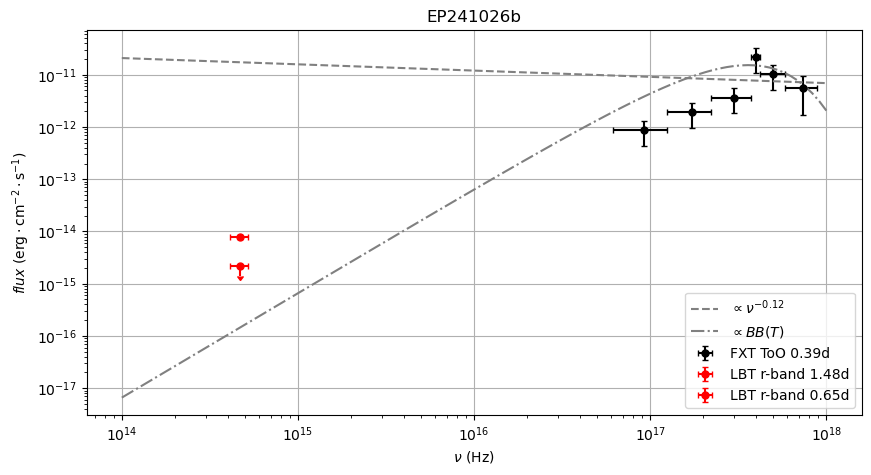

In [10]:
'calculate band flux'
'Lets plot SED of EP241026b'
'WXT observations at 2024-10-26 18:11:15'
'FXT 1st ToO started at 2024-10-27 03:36:23'
'FXT 2nd ToO started at 2024-10-30 03:49:03'
'LBT observations 1.48d post trigger, r=21.6'
from astropy.time import Time

import EPTools.model
dt_FXT = Time('2024-10-27T03:36:23',format='isot', scale='utc').mjd - Time('2024-10-26T18:11:15',format='isot', scale='utc').mjd

'Load FXT ToO data'
fxt_sed = np.loadtxt('/Users/liangrunduo/EP/EP-TA-data/EP241026b/ep06800000178_FXTA_0301_s1/FXT_SED_1.txt',skiprows=3)
#fxt_sed = np.loadtxt('/Users/liangrunduo/EP/EP-TA-data/EP241026b/ep06800000188_FXTB_0101_s1/FXT_SED_2.txt',skiprows=3)
energy, energy_err, flux_kev,flux_kev_err = fxt_sed[:,0], fxt_sed[:,1], fxt_sed[:,2], fxt_sed[:,3]
x_nus = keV2Hz(energy)
x_nus_err = keV2Hz(energy+energy_err) - x_nus
x_flux = flux_kev * keV2erg(energy)
x_flux_err = flux_kev_err * keV2erg(energy)

LBT_wave, fwhm = EPTools.utils.band_wavelength['R']
LBT_nu = lam2Hz(LBT_wave)
LBT_nu_err = lam2Hz(LBT_wave-0.5*fwhm) - LBT_nu
LBT_flux = mag2flx(21.6,LBT_wave,fwhm)
mag_err = 0.2
LBT_flux_err = mag2flx(21.5,LBT_wave,fwhm) - mag2flx(21.6,LBT_wave,fwhm)
save_txt = np.array([[Hz2keV(lam2Hz(LBT_wave+0.5*fwhm)),Hz2keV(lam2Hz(LBT_wave-0.5*fwhm)),LBT_flux,LBT_flux_err]])
np.savetxt('/Users/liangrunduo/EP/EP-TA-data/EP241026b/LBT_2.txt',save_txt,delimiter=' ')
LBT_uplim = mag2flx(23,LBT_wave,fwhm)

'Plot data'
fig, ax = plt.subplots(figsize=(10,5),dpi=100)
ax.errorbar(x=x_nus,y=x_flux,xerr=x_nus_err,yerr=x_flux_err,capsize=2,fmt='o',markersize=5,color='k',label='FXT ToO {:.2f}d'.format(dt_FXT))
ax.errorbar(x=LBT_nu,y=LBT_flux,xerr=LBT_nu_err,yerr=LBT_flux_err,capsize=2,fmt='o',markersize=5,color='r',label='LBT r-band 1.48d')
ax.errorbar(x=LBT_nu,y=LBT_uplim,xerr=LBT_nu_err,yerr=LBT_flux_err,capsize=2,fmt='o',markersize=5,color='r',uplims=True,label='LBT r-band {:.2f}d'.format(15.6/24))


model_bb = EPTools.model.BlackBody()
T = keV2T(0.528383)   # from XSPEC

mo_nus = np.logspace(14,18,100)
y_bb = 3.5e-16*model_bb.calc_spectra(T,mo_nus)
y = 1e-9*mo_nus**(-0.12)
ax.plot(mo_nus,y,ls='--',color='gray',label=r'$\propto \nu^{-0.12}$')
ax.plot(mo_nus,y_bb,ls='-.',color='grey',label=r'$\propto BB(T)$')

ax.set_xscale('log')
ax.set_yscale('log')
#ax.invert_xaxis()
ax.grid()
ax.set_xlabel(r'$\nu$ (Hz)')
ax.set_ylabel(r'$flux\ (\mathrm{erg}\cdot \mathrm{cm}^{-2} \cdot \mathrm{s}^{-1})$')
ax.legend()
ax.set_title('EP241026b')
plt.savefig('/Users/liangrunduo/EP/EP-TA-data/EP241026b/prelimiary_FXT1_LBT.pdf',dpi=300)

## Plot and fit long-term flares